### Maximization of acoustic energy difference between two spaces

In [1]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
import librosa
import os
import LoudspeakerArray
import MicrophoneArray
from LoudspeakerArray import print_ArrayInfo, CircularArray10, SphericalArray40
from tools import sph2cart, calculateDirections
from plot_tools import plot_array, verify_shapeofArray, plot_total, plot_loudspeaker_dir
from scipy.spatial import distance_matrix

print(os.getcwd())

/Users/wenmiao/Majority/Code/Paper_reproduction/Maximization_of_acoustic_energy_difference_between_two_spaces


In [2]:
class config:
    # Speaker array type
    spkArray = CircularArray10()           # SphericalArray40(), CircularArray10()
    print_ArrayInfo(spkArray)
    # Bright field range and dark field range
    bright_field_xrange = [1.2, 1.8]      # from paper
    bright_field_yrange = [1.71, 2.27]
    distance_2mics = 0.05
    distance_2fields = 0.4
    # The directivity of the loudspeaker 
    loudspeaker_dir = "OMNI"              #- HYPERCARDIOID, CARDIOD, OMNI
    # Setting for the simulating room
    max_order = 0                         # Maximum order for reflections
    absorption = 1.0                      # The absorption coefficient for all the walls in room
    fs = 48000                            # Sampling rate
    f = 10000                             # The up bound frequency
    N = 48000                             # The NFFT samples
    # ACC method
    method = "AED"     #- ACC_without_constraint , ACC_with_constraint, AED
    delta = 1e-5                          # Hyperparameter for ACC with constraint
    alpha = 987                          # Hyperparameter for AED
    # Reproduction
    resolution = 40                       # The resolution for sound field reproduction    
    distance_rep = 0                    # The different positions to reproduce the sound field in order to avoid overfitting

Name: Circular 10
Array Type: Planar Array
Number of elements: 10
Directivity: omni


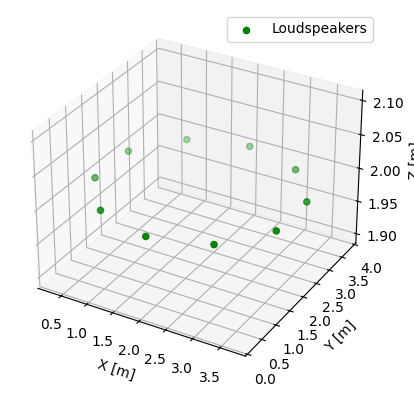

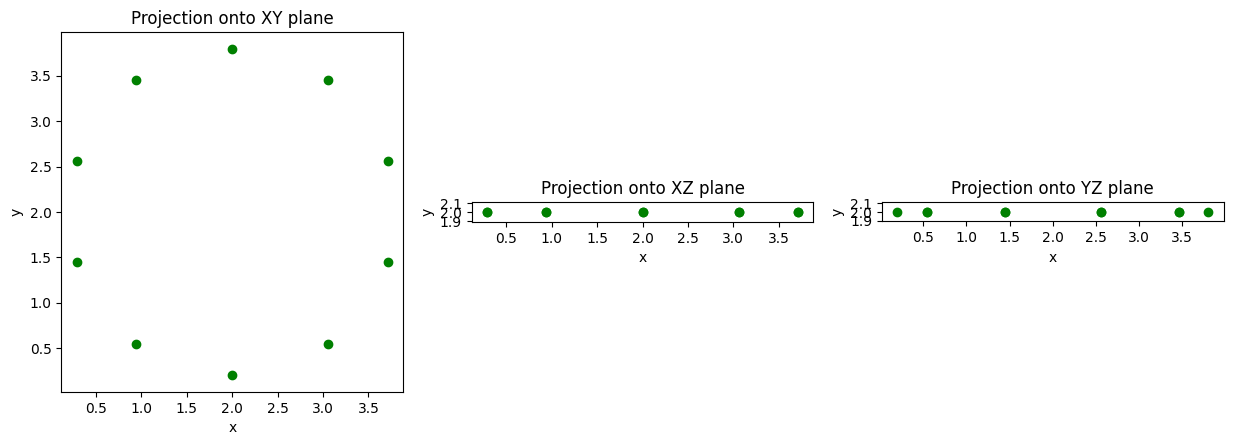

In [3]:
## Initialize the loudspeaker array
spkArray = config.spkArray
thetas = spkArray._thetas 
phis = spkArray._phis
radius = spkArray._radius
weights = spkArray._weights

# Initialize the list of spk position in spherical coordinate
spk_pos_sph = []

for theta, phi in zip(thetas, phis):
    spk_pos_sph.append([radius, theta, phi])
spk_pos_sph = np.array(spk_pos_sph)

spk_pos_car = [sph2cart(r, theta, phi) for r, theta, phi in spk_pos_sph]
spk_pos_car = np.array(spk_pos_car)
spk_pos_car = spk_pos_car + 2
plot_array(spk_pos_car, "Loudspeakers") 
verify_shapeofArray(spk_pos_car)

Name: Cube Mic Array
Array Type: Open Spherical
Number of Elements: 1200
Directivity: Omni


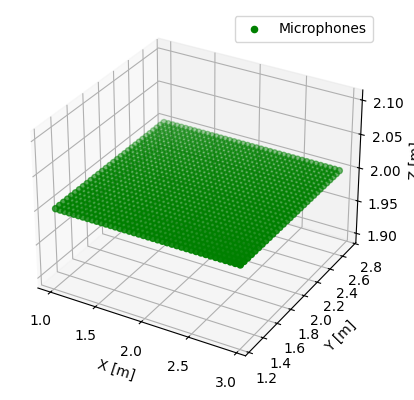

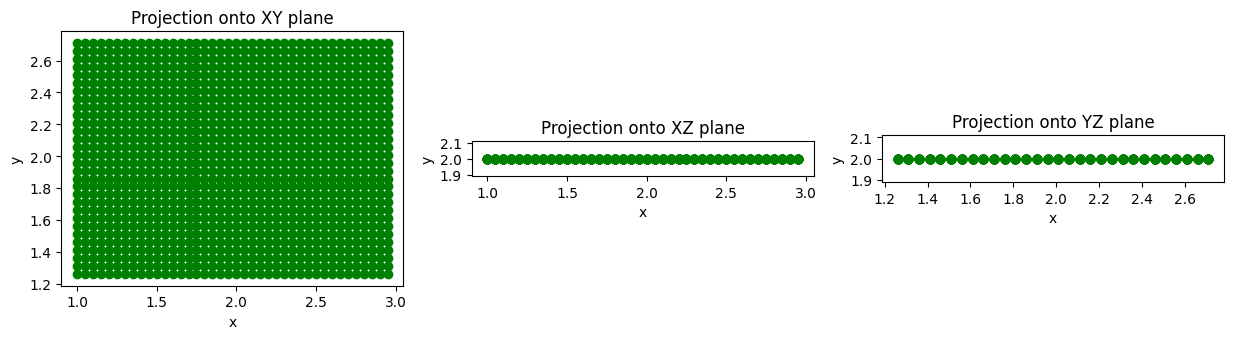

In [4]:
## Initialize the microphone array (The whole sampling area bigger than control area)
micArray = MicrophoneArray.PlanarArray()
name = micArray.getname()
array_type = micArray.gettype()
xs = micArray._x
ys = micArray._y
zs = micArray._z
z = 0
weights = micArray._weights
num_elements = micArray._numelements
directivity = micArray._directivity

# Initialize the list of mic_position in cartesian coordinates
mic_pos_car = []    
# for each theta and phi, create a new coordinate which contains all parameters
# to the list of mic_ pos
for x, y in zip(xs, ys):
    mic_pos_car.append([x, y, z])
mic_pos_car = np.array(mic_pos_car)
mic_pos_car = mic_pos_car + 2
print ("Name:", name)
print ("Array Type:", array_type) 
print ("Number of Elements:", num_elements)
print("Directivity:", directivity)
plot_array(mic_pos_car, "Microphones")
verify_shapeofArray(mic_pos_car)


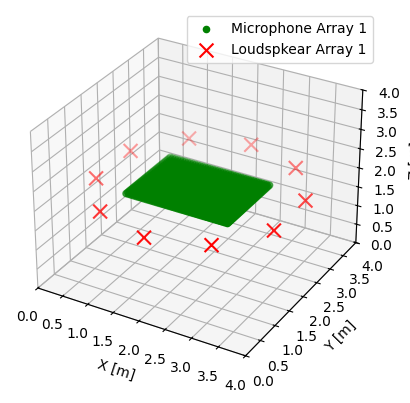

In [5]:
## Plot the microphone array and loudspeaker array together, not for computing
room = pra.AnechoicRoom(fs=48000)
room_dim = [4,4,4]
room.add_microphone_array(pra.MicrophoneArray(np.array(mic_pos_car).T, room.fs))
for source_pos_car in spk_pos_car:
    room.add_source(source_pos_car)

room.compute_rir()
rt60_real = room.measure_rt60()
# print( "The measured RT60 is {}".format(rt60_real[1, 0]))
plot_total(room_dim, [mic_pos_car],[spk_pos_car])


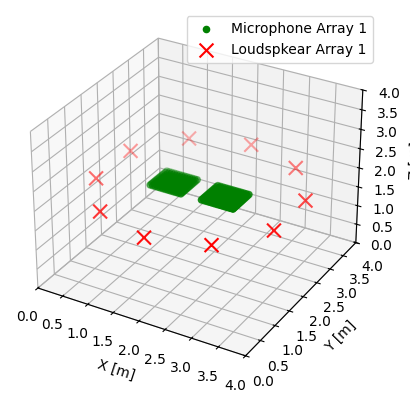

In [6]:
## Initilize the bright field and dark field
bright_field_x = np.arange(config.bright_field_xrange[0], config.bright_field_xrange[1], config.distance_2mics)
bright_field_y = np.arange(config.bright_field_yrange[0], config.bright_field_yrange[1], config.distance_2mics)
bright_field_z = 2.0

bright_field_x, bright_field_y = np.meshgrid(bright_field_x, bright_field_y)
bright_field = np.column_stack((bright_field_x.ravel(), bright_field_y.ravel(), np.full(bright_field_x.size, bright_field_z)))


dark_field = bright_field.copy()
dark_field[:, 0] += config.distance_2fields + (config.bright_field_xrange[1] - config.bright_field_xrange[0])
# If the speaker array is sphercal, planar area will be extended to 3D control area
if (np.size(np.array([source_pos_car])) / 3 == 40):
    bright_field_list = bright_field.tolist()
    dark_field_list = dark_field.tolist()
    
    for points in bright_field:
        for i in range(-6, 6, 1):
            new_points = [points[0], points[1], points[2] + 0.05 * i]
            bright_field_list.append(new_points)
    
    for points in dark_field:
        for i in range(-6, 6, 1):
            new_points = [points[0], points[1], points[2] + 0.05 * i]
            dark_field_list.append(new_points)
    
    bright_field = np.array(bright_field_list)
    dark_field = np.array(dark_field_list)

# print(bright_field)
# print(dark_field)   

            
bright_field = np.array(bright_field)
dark_field = np.array(dark_field)
total_field = np.concatenate((bright_field, dark_field))

plot_total(room_dim, [total_field], [spk_pos_car])

In [7]:
## Simulate a room to get the corresponding room impulse response between mic array and loudspeaker array
loudspeaker_dir = pra.directivities.DirectivityPattern[config.loudspeaker_dir]
target_point = np.mean(bright_field, axis=0)
directions = calculateDirections(spk_pos_car, target_point)


room_dim = [4,4,4]

room = pra.ShoeBox(room_dim, fs=config.fs, max_order=config.max_order, absorption=config.absorption)
room.add_microphone_array(pra.MicrophoneArray(np.array(total_field).T, room.fs))
for i, source_pos_car in enumerate(spk_pos_car):
    azimuth = np.arctan2(directions[i][1], directions[i][0])
    orientation = pra.directivities.DirectionVector(azimuth=azimuth, degrees=False)
    dir = pra.directivities.CardioidFamily(orientation=orientation, pattern_enum=loudspeaker_dir)
    room.add_source(position= source_pos_car, directivity= dir)


room.compute_rir()
rt60_real = room.measure_rt60()
print( "The measured RT60 is {}".format(rt60_real[1, 0]))

The measured RT60 is 0.0006874999999999989


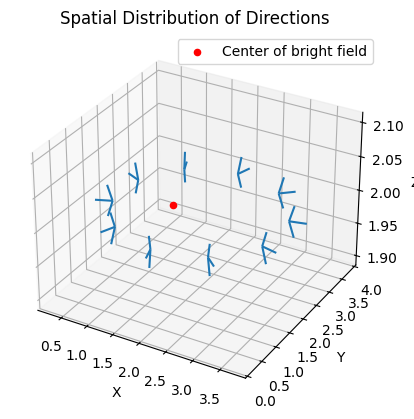

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, (pos, dir) in enumerate(zip(spk_pos_car, directions)):
    ax.quiver(pos[0], pos[1], pos[2], dir[0], dir[1], dir[2], length=0.3, normalize=True)
bright_field_center = np.mean(bright_field, axis=0)
ax.scatter(bright_field_center[0], bright_field_center[1], bright_field_center[2], c='red', marker='o', label='Center of bright field')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Spatial Distribution of Directions')
ax.legend()
plt.show()

In [9]:
## Transfer the RIR to Transfer function
freq_bins = np.fft.fftfreq(config.N, 1/config.fs)[:config.N//2]  
max_bin = np.argmax(freq_bins >= config.f)  

TF_total_bright = []
TF_total_dark = []

bright_len = len(bright_field)
dark_len = len(dark_field)

for i in range(len(spk_pos_car)):
    TF_temp_bright = np.zeros((bright_len, max_bin), dtype=complex)
    TF_temp_dark = np.zeros((dark_len, max_bin), dtype=complex)
    for j in range(bright_len):
        TF_b = np.fft.fft(room.rir[j][i], config.N)
        TF_temp_bright[j] = TF_b[:max_bin]
    for k in range(dark_len):
        TF_d = np.fft.fft(room.rir[bright_len + k][i], config.N)
        TF_temp_dark[k] = TF_d[:max_bin]
    TF_total_bright.append(TF_temp_bright)
    TF_total_dark.append(TF_temp_dark)


In [10]:
## Implementing the ACC
TF_total_bright = np.array(TF_total_bright).T
TF_total_dark = np.array(TF_total_dark).T
w_total = []


for k in range(config.f):
    TF_array_b = TF_total_bright[k]
    RB = np.transpose(TF_array_b.conj()) @ TF_array_b
    TF_array_d = TF_total_dark[k]
    RD = np.transpose(TF_array_d.conj()) @ TF_array_d
    if config.method == "ACC_without_constraint":
        matrix = np.linalg.pinv(RB + RD) @ RB
    elif config.method == "ACC_with_constraint":
        matrix = np.linalg.pinv(RD + config.delta * np.eye(np.size(RD.shape[0]), dtype=complex)) @ RB
    elif config.method == "AED":
        matrix = (RB - config.alpha * RD) 
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    max_eigenvalue_index = np.argmax(eigenvalues)
    max_eigenvalue = eigenvalues[max_eigenvalue_index]
    corresponding_eigenvector = eigenvectors[:, max_eigenvalue_index]

    w = corresponding_eigenvector
    w_total.append(w)


In [11]:
## reproduce the sound field in another room
resolution = 100
X = np.linspace(1, 3, resolution)
Y = np.linspace(1.26, 2.71, resolution)
x_pred, y_pred = np.meshgrid(X,Y)
x_pred = x_pred.reshape(-1)
y_pred = y_pred.reshape(-1)
z_pred = np.zeros(len(x_pred))
points = np.transpose([x_pred, y_pred, z_pred])

bright_field_rep = bright_field + np.array([config.distance_rep, 0, 0])
dark_field_rep = dark_field + np.array([config.distance_rep, 0, 0])
total_points = np.concatenate((bright_field_rep, dark_field_rep, points))

room_dim = [4,4,4]

room = pra.ShoeBox(room_dim, fs=config.fs, max_order=config.max_order, absorption=config.absorption)
room.add_microphone_array(pra.MicrophoneArray(np.array(total_points).T, room.fs))

loudspeaker_dir = pra.directivities.DirectivityPattern[config.loudspeaker_dir]
target_point = np.mean(bright_field, axis=0)
directions = calculateDirections(spk_pos_car, target_point)

for i, source_pos_car in enumerate(spk_pos_car):
    azimuth = np.arctan2(directions[i][1], directions[i][0])
    orientation = pra.directivities.DirectionVector(azimuth=azimuth, degrees=False)
    dir = pra.directivities.CardioidFamily(orientation=orientation, pattern_enum=loudspeaker_dir)
    room.add_source(position=source_pos_car, directivity= dir)
    

room.compute_rir()
rt60_real = room.measure_rt60()
print( "The measured RT60 is {}".format(rt60_real[1, 0]))

TF_total_p = []
TF_rep_b = []
TF_rep_d = []
for i in range(len(spk_pos_car)):
    TF_temp_p = np.zeros((len(points),config.f), dtype=complex)
    TF_temp_bright = np.zeros((len(bright_field_rep), config.f), dtype=complex)
    TF_temp_dark = np.zeros((len(dark_field_rep), config.f), dtype=complex)
    for j in range(bright_len):
        TF_b = np.fft.fft(room.rir[j][i], config.N)
        TF_temp_bright[j] = TF_b[:max_bin]
    for k in range(dark_len):
        TF_d = np.fft.fft(room.rir[bright_len + k][i], config.N)
        TF_temp_dark[k] = TF_d[:max_bin]
    for l in range(len(points)):
        TF_p = np.fft.fft(room.rir[bright_len + dark_len + l][i], config.N)
        TF_temp_p[l] = TF_p[:config.f]
    TF_total_p.append(TF_temp_p)
    TF_rep_b.append(TF_temp_bright)
    TF_rep_d.append(TF_temp_dark)
TF_total_p = np.array(TF_total_p).T
TF_rep_b = np.array(TF_rep_b).T
TF_rep_d = np.array(TF_rep_d).T

The measured RT60 is 0.0006874999999999989


Acoustic Contrast at 100 Hz: 34.16 dB
Acoustic Contrast at 500 Hz: 27.04 dB
Acoustic Contrast at 4000 Hz: 5.12 dB
Average Acoustic Contrast in the frequency range (0, 10000): 6.65 dB


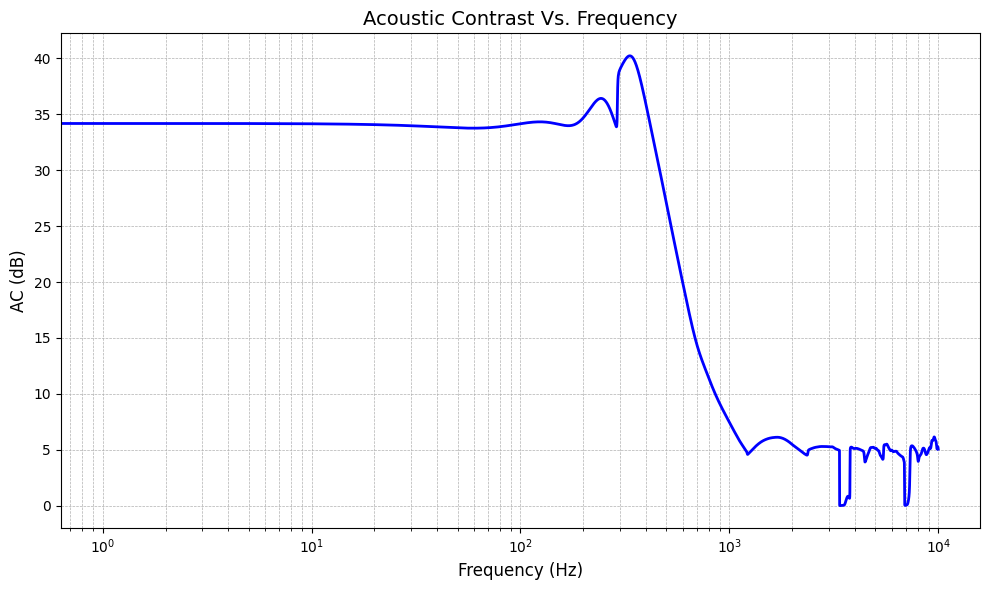

In [12]:
## The Acoustic Contrast between bright area and dark area
AC_total = []
selected_frequencies = [100, 500, 4000]

for i in range(config.f):
    pB = TF_rep_b[i] @ w_total[i]
    EB = np.conj(pB).T @ pB
    pD = TF_rep_d[i] @ w_total[i]
    ED = np.conj(pD).T @ pD
    AC = 10 * np.log10(np.abs(EB) / np.abs(ED))

    if i in selected_frequencies:
        print(f"Acoustic Contrast at {i} Hz: {AC:.2f} dB")

    AC_total.append(AC)

plt.figure(figsize=(10, 6))
plt.semilogx(range(config.f), AC_total, linewidth=2, color='b')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.title("Acoustic Contrast Vs. Frequency", fontsize=14)
plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel('AC (dB)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

average_AC = np.mean(AC_total)
print('Average Acoustic Contrast in the frequency range (0, {}): {:.2f} dB'.format(config.f, average_AC))

plt.show()

In [13]:
G_pred = np.array(TF_total_p)
p_pred_dB = []
for i in range(config.f):
    p_pred_temp = G_pred[i] @ w_total[i]
    p_pred_dB_temp = 20*np.log10(np.abs(p_pred_temp))
    p_pred_dB.append(p_pred_dB_temp)
w_total = np.array(w_total)


34.70128285109789


/var/folders/cp/qh076_c520z12k3l0807brbr0000gn/T/ipykernel_53833/3133203134.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


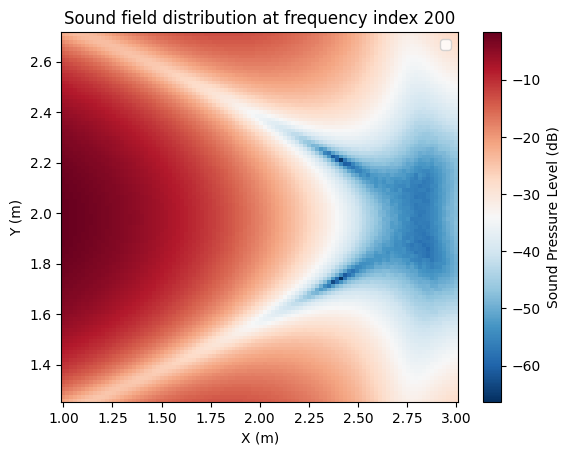

In [16]:
# get the sound field distribution
i = 200
print(AC_total[i])
p_pred_dB_reshape = np.array(p_pred_dB[i]).reshape(resolution, resolution)
plt.figure()
plt.pcolor(X, Y, p_pred_dB_reshape, cmap='RdBu_r')
# plt.pcolor(X, Y, p_pred_dB_reshape, cmap='inferno')
plt.colorbar(label='Sound Pressure Level (dB)')
# plt.scatter(bright_field[:, 0], bright_field[:, 1], c='blue', label='Bright field')
# plt.scatter(dark_field[:, 0], dark_field[:, 1], c='k', label='Dark field')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.legend()
plt.title(f'Sound field distribution at frequency index {i}')
plt.show()